In [1]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import math
%run ./labeling.ipynb
from tqdm.auto import tqdm

Using TensorFlow backend.
C:\Users\afecn\anaconda3.1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\afecn\anaconda3.1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\afecn\anaconda3.1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\afecn\anaconda3.1\lib\site-packages\tensorflow\python\framework\d

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#FOR REPRODISIBILITY

In [8]:
def train_cnn(training_df, test_df, params):
    """Trains and evaluates CNN on the given train and test data, respectively."""

    print("Training is starting ...")
    train_images = training_df.iloc[:, 3:].to_numpy()  # bu satır son sütun hariç her şeyi resimler dataframeine atar.
    train_labels = training_df.loc[:, 0]    # bu satır sadece son sütunu alır.
    train_prices = training_df.loc[: ,1]

    test_images = test_df.iloc[:, 3:].to_numpy()  # bu satır son sütun hariç her şeyi resimler dataframeine atar.
    test_labels = test_df.loc[:, 0]   # bu satır sadece son sütunu alır.
    test_prices = test_df.loc[:, 1]

    test_labels = keras.utils.to_categorical(test_labels, params["num_classes"])
    train_labels = keras.utils.to_categorical(train_labels, params["num_classes"])

#create pictures simple reshaping 225 in 15x15+1
    train_images = train_images.reshape(train_images.shape[0], params["input_w"], params["input_h"], 1) 
    test_images = test_images.reshape(test_images.shape[0], params["input_w"], params["input_h"], 1)



    # CNN model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(params["input_w"], params["input_h"], 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params["num_classes"], activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, #not categorical_crossentropy
                  optimizer=keras.optimizers.Adadelta(), #not Adam
                  metrics=['accuracy', 'mae', 'mse']) #plus two

    # metrics.accuracy_score, metrics.recall_score, metrics.average_precision_score, metrics.confusion_matrix
    train_data_size = train_images.shape[0]
    test_data_size = test_images.shape[0]


    print("model will be trained with {} and be tested with {} sample".format(train_data_size,test_data_size))
    # fit the model to the training data
    print("Fitting model to the training data...")
    print("")
    model.fit(train_images, train_labels, batch_size=params["batch_size"], epochs=params["epochs"], verbose=0,validation_data=None)

    predictions = model.predict(test_images, batch_size=params["batch_size"], verbose=0)
    print(model.evaluate(test_images, test_labels, batch_size=params["batch_size"], verbose=0))
    
    predictions_train = model.predict(train_images, batch_size=params["batch_size"], verbose=0)
    print(model.evaluate(train_images, train_labels, batch_size=params["batch_size"], verbose=0))

    print("Train conf matrix: ") 
    print(confusion_matrix(np.array(reverse_one_hot(train_labels)),
                                                  np.array(reverse_one_hot(model.predict(train_images, batch_size=params["batch_size"], verbose=0)))))

    print("Test conf matrix: ") 
    print(confusion_matrix(np.array(reverse_one_hot(test_labels)),
                                                  np.array(reverse_one_hot(predictions))))



    # cur_pointer = train_data_size + 1
    # print("Calculating accuracy day by day...", end='\n\n')
    # for i in range(test_data_size-2):
    #     # train with 1 more image
    #     model.train_on_batch(np.reshape(data[train_data_size + 1 + i, :], (1, params["input_w"], params["input_h"], 1)),
    #                         np.reshape(labels[train_data_size + 1 + i, :], (1, params["num_classes"])))
    #
    #     # test with first untrained day which is the day after previously trained one
    #     loss_cur,acc_cur = model.test_on_batch(np.reshape(data[train_data_size + 1 + i + 1, :], (1, params["input_w"], params["input_h"], 1)),
    #                         np.reshape(labels[train_data_size + 1 + i + 1, :], (1, params["num_classes"])))
    #
    #     accuracies.append(acc_cur)
    #     losses.append(loss_cur)
    #
    #     # show values every 100 cycle
    #     if i % 100 == 0:
    #         print("{} to {} mean : ".format(i-100,i), np.mean(accuracies))

    return predictions, test_labels, test_prices, predictions_train, train_labels, train_prices

def reverse_one_hot(predictions):
    reversed_x = []
    for x in predictions:
        reversed_x.append(np.argmax(np.array(x)))
    return reversed_x

def profit():
    k = 10 #УБИРАЕМ ВЫСОКИЕ ПРОЦЕНТЫ

    result_df = pd.DataFrame({"prediction": np.argmax(predictions, axis=1),
                              "test_label":np.argmax(test_labels, axis=1),
                             "test_price":test_prices})

    result_df_train = pd.DataFrame({"prediction": np.argmax(predictions_train, axis=1),
                              "test_label":np.argmax(train_labels, axis=1),
                             "test_price":train_prices})
    #result_df.to_excel("cnn_result.xlsx", index=None)


    print('test')
    result_df['test_price_1'] = (result_df['test_price'].shift(-1)/result_df['test_price']-1)*100
    result_df = result_df[result_df['test_price_1']>-k]
    result_df = result_df[result_df['test_price_1']< k]
    aa = pd.pivot_table(result_df, values = 'test_price_1', index='prediction', aggfunc=['mean', 'count'], margins=True)
    display(aa)

    print('train')
    result_df_train['test_price_1'] = (result_df_train['test_price'].shift(-1)/result_df_train['test_price']-1)*100
    result_df_train = result_df_train[result_df_train['test_price_1']>-k]
    result_df_train = result_df_train[result_df_train['test_price_1']< k]
    bb = pd.pivot_table(result_df_train, values = 'test_price_1', index='prediction', aggfunc=['mean', 'count'], margins=True)
    display(bb)


In [220]:
#ТУРЕЧИНА
train_df = pd.read_csv("E:/Host/Data/Bees/finance_ML/CNN-TA/data/1/outputOfPhase2Training.csv", header=None, index_col=None, delimiter=';')
test_df  = pd.read_csv("E:/Host/Data/Bees/finance_ML/CNN-TA/data/1/outputOfPhase2Test.csv", header=None, index_col=None, delimiter=';')

# sonundaki ; den dolayı son sütun nan geliyor.
train_df = train_df.iloc[:,:-1]
test_df = test_df.iloc[:,:-1]

# drop nan values
train_df = train_df.dropna(axis=0)
test_df = test_df.dropna(axis=0)

# drop first 15 row
train_df = train_df.iloc[15:, :]
test_df = test_df.iloc[15:,:]

#СВОИ ЛЕЙБЛЫ

# return_ = np.array((train_df[1].shift(-1)/train_df[1].shift(0)-1)*100)
# pl_mi   = np.array(np.where(return_ > 1.5,1, np.where(return_ < -1.5, 2, 0)))
# price   = np.array(train_df[1])
# return_ = pd.concat([pd.Series(price), pd.Series(return_),(pd.Series(pl_mi))], axis=1)
# train_df[0] = pl_mi
# train_df

In [5]:
%%time

# ГОТОВИМ ТРАЙН И ТЕСТ ИЗ TALIB С ЗАГРУЗКИ ДО КОНЦА
df1 = pd.read_csv("E:/Host/Data/Bees/finance_ML/df3.csv")

#ДОБАВИЛ +/-И ЦЕНУ
return_ = np.array((df1['close'].shift(-1)/df1['close'].shift(0)-1)*100)
pl_mi   = np.array(np.where(return_ > 1.5, 1, np.where(return_ < -1.5, 0, 2)))
price   = np.array(df1['close'])
df1[0] = pl_mi
df1[1] = price
df1[2] = return_
#СГРУПИРОВАЛИ ПО СИМБОЛАМ И РАЗБИЛИ И СНОВА СОБРАЛИ НА ТЕСТ И ТРАЙН
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for yy in ['GAZP', 'GMKN', 'LKOH', 'ROSN', 'SBER', 'SBERP', 'VTBR']:
    
    df_f = df1[df1['symbol'] == yy]
    
#     a, b = create_labels(df_f.iloc[:,:], 'close') #запуск лейбла из labling
#     display(b)
#     df_f[0] = a #перезапись вместо простого
    
    df_f_train = df_f.iloc[:int(len(df_f)*0.9), :]
    df_f_test  = df_f.iloc[int(len(df_f)*0.9):, :]
    train_df = train_df.append(df_f_train)
    test_df  = test_df.append(df_f_test)
#display(train_df)
#display(test_df)
# СКОМПОНОВАЛИ ПРАВИЛЬНЫЕ СТОЛБЦЫ
train_df = train_df[[0,1,2] + list(train_df.columns[8:-4])]
test_df  = test_df [[0,1,2]  + list(test_df.columns[8:-4])]
#print('result')
display(train_df.shape)
display(test_df.shape)
    

C:\Users\afecn\anaconda3.1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\Users\afecn\anaconda3.1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


(21123, 292)

(2352, 292)

Wall time: 3.7 s


In [6]:
#ПОЧИСТИМ ОТ НАНОВ
display(train_df.shape)
display(test_df.shape)
display(np.unique(train_df[0], return_counts=True))
display(np.unique(test_df[0],  return_counts=True))
train_df.fillna(2, inplace=True)
test_df.fillna(2, inplace=True)
display(np.unique(train_df[0], return_counts=True))
display(np.unique(test_df[0],  return_counts=True))
display(train_df.shape)
display(test_df.shape)

(21123, 292)

(2352, 292)

(array([0, 1, 2]), array([ 3813,  4108, 13202], dtype=int64))

(array([0, 1, 2]), array([ 305,  350, 1697], dtype=int64))

(array([0, 1, 2]), array([ 3813,  4108, 13202], dtype=int64))

(array([0, 1, 2]), array([ 305,  350, 1697], dtype=int64))

(21123, 292)

(2352, 292)

In [21]:
%%time

# УРАВНИВАЕМ ВЫБОРКУ 1 2 3

l0_train = train_df.loc[train_df[0] == 0]
l1_train = train_df.loc[train_df[0] == 1]
l2_train = train_df.loc[train_df[0] == 2]
l0_size = l0_train.shape[0]
l1_size = l1_train.shape[0]
l2_size = l2_train.shape[0]
#l0_l1_ratio = int((l0_size//l1_size)/4)
#l0_l2_ratio = int((l0_size//l2_size)/4)

l0_l1_ratio = (l0_size//l1_size)
l0_l2_ratio = (l0_size//l2_size)
print("Before")
print("l0_size:",l0_size,"l1_size:", l1_size,"l2_size:",l2_size)
print("l0_l1_ratio:",l0_l1_ratio,"l0_l2_ratio:", l0_l2_ratio)

l1_new = pd.DataFrame()
l2_new = pd.DataFrame()
for idx, row in train_df.iterrows():
    if row[0] == 1:
        for i in range(l0_l1_ratio):
            l1_new = l1_new.append(row)
    if row[0] == 2:
        for i in range(l0_l2_ratio):
            l2_new = l2_new.append(row)

train_df = train_df.append(l1_new)
train_df = train_df.append(l2_new)



########################################################
l0_train = train_df.loc[train_df[0] == 0]
l1_train = train_df.loc[train_df[0] == 1]
l2_train = train_df.loc[train_df[0] == 2]
l0_size = l0_train.shape[0]
l1_size = l1_train.shape[0]
l2_size = l2_train.shape[0]
#l0_l1_ratio = int((l0_size//l1_size)/4)
#l0_l2_ratio = int((l0_size//l2_size)/4)

l0_l1_ratio = (l0_size//l1_size)
l0_l2_ratio = (l0_size//l2_size)
print("After")
print("l0_size:",l0_size,"l1_size:", l1_size,"l2_size:",l2_size)
print("l0_l1_ratio:",l0_l1_ratio,"l0_l2_ratio:", l0_l2_ratio)

######################################################


train_df.reset_index(drop=True, inplace=True)
test_df.reset_index (drop=True, inplace=True)

print("train_df size: ", train_df.shape)
#print(train_df.columns)


Before
l0_size: 1290 l1_size: 1311 l2_size: 18522
l0_l1_ratio: 0 l0_l2_ratio: 0
After
l0_size: 1290 l1_size: 1311 l2_size: 18522
l0_l1_ratio: 0 l0_l2_ratio: 0
train_df size:  (21123, 292)
Wall time: 1.78 s


In [77]:
# # shuffle
# #train_df = shuffle(train_df)  #ЗАКОМЕНТИЛ!!!!!!!!!!!!!!
# print(list(train_df.columns))
# train_df.columns = list(range(0,291))
# print(list(train_df.columns))
# # shuffle all!!!!
# train_df = np.transpose(shuffle(np.transpose(train_df.loc[:, :])))
# #ПРИВЕЛ В ПОРЯДОК
# train_df = train_df[[0,1] + shuffle(list(range(2,291)))]
# print(list(train_df.columns))
# train_df

In [7]:
test_df

,0,1,ADX_2,ADX_3,ADX_4,ADX_5,ADX_10,ADX_28,ADXR_2,ADXR_3,...,STOCHRSI_fastk,STOCHRSI_fastd,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,MAMA_mama
2787,0,132.280000,0.314672,-0.093550,-0.344437,-0.487267,-0.644011,-0.707232,0.028343,-0.251058,...,1.000000,-0.182089,-0.070274,-0.119200,-0.999949,-0.714277,-0.988846,-0.988640,-0.988839,-0.988311
2788,0,132.300000,0.591116,0.182888,-0.099354,-0.278324,-0.540237,-0.674363,0.430540,-0.190980,...,1.000000,0.484578,-0.070227,-0.119467,0.950370,0.452015,-0.988645,-0.988526,-0.988823,-0.988297
2789,0,131.500000,0.394303,0.233227,0.006743,-0.163296,-0.463737,-0.646265,0.471994,0.031632,...,0.575543,0.858514,-0.070132,-0.119371,0.937415,0.416628,-0.988563,-0.988437,-0.988730,-0.988252
2790,0,132.500000,0.466521,0.323925,0.120444,-0.046522,-0.383524,-0.614967,0.407133,0.224208,...,0.789107,0.788217,-0.070127,-0.119489,0.883516,0.293530,-0.988540,-0.988315,-0.988505,-0.988239
2791,0,133.320000,0.553570,0.403358,0.217065,0.055065,-0.307648,-0.583416,0.490044,0.292278,...,0.881641,0.748764,-0.070188,-0.118618,0.793094,0.130104,-0.988742,-0.988182,-0.988015,-0.988082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23470,0,0.036720,0.435219,-0.014808,-0.179933,-0.247614,-0.294007,-0.637749,0.311652,-0.102823,...,-1.000000,-1.000000,-0.070418,-0.119731,-0.563538,-0.982615,-0.999998,-0.999998,-0.999998,-0.999998
23471,0,0.036755,0.548040,0.072608,-0.150330,-0.256614,-0.349153,-0.657346,0.470870,-0.070134,...,-0.983100,-0.994367,-0.070418,-0.119730,-0.670690,-0.998737,-0.999998,-0.999998,-0.999998,-0.999999
23472,1,0.036930,-0.304551,-0.176461,-0.278979,-0.352487,-0.419774,-0.672588,0.085761,-0.141961,...,-0.744532,-0.909211,-0.070418,-0.119731,-0.764096,-0.996454,-0.999998,-0.999998,-0.999998,-0.999999
23473,0,0.037680,-0.353327,-0.512141,-0.463196,-0.481565,-0.495838,-0.684733,-0.383471,-0.272184,...,0.986753,-0.246960,-0.070418,-0.119732,-0.888286,-0.952881,-0.999998,-0.999998,-0.999998,-0.999999


In [9]:
%%time
prifit = pd.DataFrame()
for i in range(100):
    # fill params dict before call train_cnn
    params = {"input_w": 17, "input_h": 17, "num_classes": 3, "batch_size": 1024, "epochs": 200}
    #params = {"input_w": 15, "input_h": 15, "num_classes": 3, "batch_size": 1024, "epochs": 100}
    # Buraya kadar olan yöntime izleyip verini fonksiyona yollayabilirsin.
    # Örneğin şu şekilde.
    predictions, test_labels, test_prices, predictions_train, train_labels, train_prices = train_cnn(train_df, test_df, params)
    print(i)
    profit()

Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8340320627705581, 0.7023809552192688, 0.2939338982105255, 0.1526622474193573]
[0.6806184865277876, 0.7224826216697693, 0.2894890010356903, 0.1295984834432602]
Train conf matrix: 
[[ 1155   218  2440]
 [  170  1387  2551]
 [  230   253 12719]]
Test conf matrix: 
[[  17   50  238]
 [  16   50  284]
 [  47   65 1585]]
0
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.086775,80
1,-0.150058,160
2,0.067807,2096
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.420903,1490
1,2.282026,1776
2,0.017351,17690
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.845382847348038, 0.7070578336715698, 0.27919983863830566, 0.15121473371982574]
[0.6849031716518847, 0.7037352919578552, 0.2798638641834259, 0.1317012757062912]
Train conf matrix: 
[[  841   159  2813]
 [  110  1085  2913]
 [   92   171 12939]]
Test conf matrix: 
[[  19   46  240]
 [  16   40  294]
 [  37   56 1604]]
1
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.340444,72
1,-0.271095,136
2,0.081087,2128
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.739025,985
1,2.419154,1337
2,0.011602,18634
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8475941196590865, 0.6934523582458496, 0.30440521240234375, 0.1563200056552887]
[0.6889212139034421, 0.7227193117141724, 0.29490697383880615, 0.13130411505699158]
Train conf matrix: 
[[ 1250   221  2342]
 [  218  1406  2484]
 [  258   334 12610]]
Test conf matrix: 
[[  28   57  220]
 [  20   55  275]
 [  37  112 1548]]
2
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.502113,84
1,-0.035250,218
2,0.079171,2034
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.218139,1657
1,2.145333,1886
2,0.021939,17413
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8508507629641059, 0.699404776096344, 0.29500168561935425, 0.15503516793251038]
[0.6799688632191512, 0.7217724919319153, 0.2906232476234436, 0.12960724532604218]
Train conf matrix: 
[[ 1140   262  2411]
 [  166  1440  2502]
 [  190   346 12666]]
Test conf matrix: 
[[  17   52  236]
 [  17   45  288]
 [  45   69 1583]]
3
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.056650,77
1,-0.250731,161
2,0.074309,2098
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.476121,1429
1,2.055865,1968
2,0.013959,17559
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.835018511937589, 0.7057822942733765, 0.286310613155365, 0.1517317146062851]
[0.6919320690139746, 0.7044927477836609, 0.28626883029937744, 0.13268069922924042]
Train conf matrix: 
[[  931   117  2765]
 [  181   996  2931]
 [  145   103 12954]]
Test conf matrix: 
[[  16   42  247]
 [  16   38  296]
 [  39   52 1606]]
4
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.144625,71
1,-0.148838,126
2,0.065542,2139
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.307060,1188
1,2.701414,1149
2,0.020921,18619
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8286993677924279, 0.7104591727256775, 0.27394068241119385, 0.14920254051685333]
[0.6956868323433587, 0.6972967982292175, 0.28227347135543823, 0.1342194825410843]
Train conf matrix: 
[[  694   168  2951]
 [   66  1037  3005]
 [   54   150 12998]]
Test conf matrix: 
[[  10   48  247]
 [   8   40  302]
 [  21   55 1621]]
5
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.274253,39
1,-0.168406,136
2,0.066992,2161
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.149949,755
1,2.415600,1276
2,0.002567,18925
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8135790768123808, 0.7125850319862366, 0.2741464078426361, 0.14779584109783173]
[0.6824067975529124, 0.7078066468238831, 0.27366214990615845, 0.13185735046863556]
Train conf matrix: 
[[  914   193  2706]
 [  117  1177  2814]
 [  134   208 12860]]
Test conf matrix: 
[[  15   47  243]
 [  17   41  292]
 [  28   49 1620]]
6
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.101066,59
1,-0.255509,132
2,0.064772,2145
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.688958,1104
1,2.322999,1495
2,0.013531,18357
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8663988928405606, 0.6772959232330322, 0.309969425201416, 0.15968438982963562]
[0.6959551352333324, 0.7284950017929077, 0.2991814911365509, 0.13211242854595184]
Train conf matrix: 
[[ 1361   232  2220]
 [  213  1492  2403]
 [  303   364 12535]]
Test conf matrix: 
[[  29   55  221]
 [  26   53  271]
 [  93   93 1511]]
7
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.010614,147
1,-0.146048,195
2,0.070818,1994
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.203944,1815
1,2.128358,2002
2,0.028698,17139
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8556966664028817, 0.7015306353569031, 0.28124839067459106, 0.15343520045280457]
[0.669822009004935, 0.72205650806427, 0.2799268066883087, 0.12810587882995605]
Train conf matrix: 
[[  915   379  2519]
 [   88  1650  2370]
 [  114   401 12687]]
Test conf matrix: 
[[  15   53  237]
 [  15   50  285]
 [  40   72 1585]]
8
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.161736,70
1,0.059070,169
2,0.053653,2097
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.882829,1056
1,1.812195,2347
2,-0.025995,17553
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8324767882321157, 0.7045068144798279, 0.2912868559360504, 0.15225298702716827]
[0.6929136093991423, 0.7112152576446533, 0.2898382544517517, 0.13243058323860168]
Train conf matrix: 
[[  998   194  2621]
 [  143  1269  2696]
 [  181   265 12756]]
Test conf matrix: 
[[  23   58  224]
 [  19   51  280]
 [  52   62 1583]]
9
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.272848,93
1,-0.083293,164
2,0.072249,2079
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.429979,1262
1,2.261061,1644
2,0.005657,18050
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8589172574127613, 0.706632673740387, 0.28932294249534607, 0.15309739112854004]
[0.6979259846591196, 0.7077119946479797, 0.2911531627178192, 0.13338544964790344]
Train conf matrix: 
[[ 1033   161  2619]
 [  214  1105  2789]
 [  228   163 12811]]
Test conf matrix: 
[[  19   40  246]
 [  19   40  291]
 [  39   55 1603]]
10
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.113400,75
1,0.019745,130
2,0.054955,2131
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.156722,1402
1,2.386227,1362
2,0.028933,18192
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8437251233730186, 0.7151360511779785, 0.2532469630241394, 0.14815011620521545]
[0.70330160370476, 0.6973914504051208, 0.26471081376075745, 0.13723957538604736]
Train conf matrix: 
[[  829   121  2863]
 [  114   900  3094]
 [  117    83 13002]]
Test conf matrix: 
[[  24   41  240]
 [  16   34  300]
 [  32   41 1624]]
11
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.712998,71
1,-0.115488,109
2,0.080882,2156
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.700934,996
1,2.726516,1033
2,0.033091,18927
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.843548529407605, 0.7215136289596558, 0.26077160239219666, 0.14882782101631165]
[0.6780926069078169, 0.705439567565918, 0.26811450719833374, 0.13134577870368958]
Train conf matrix: 
[[  720   242  2851]
 [   49  1285  2774]
 [   76   230 12896]]
Test conf matrix: 
[[  12   43  250]
 [   6   46  298]
 [   7   51 1639]]
12
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-1.074435,25
1,0.064845,135
2,0.059411,2176
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.280372,792
1,2.199113,1669
2,-0.017280,18495
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8650055304676497, 0.7032312750816345, 0.28924697637557983, 0.15373307466506958]
[0.6814702604494554, 0.7177957892417908, 0.28699737787246704, 0.12995727360248566]
Train conf matrix: 
[[ 1205   111  2497]
 [  245  1089  2774]
 [  199   135 12868]]
Test conf matrix: 
[[  18   39  248]
 [  18   38  294]
 [  58   41 1598]]
13
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.106808,93
1,0.087767,112
2,0.052217,2131
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.159949,1578
1,2.706316,1267
2,0.040426,18111
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8517697149393509, 0.7070578336715698, 0.2762281000614166, 0.1515897810459137]
[0.6761814998300985, 0.7183165550231934, 0.27895742654800415, 0.12937094271183014]
Train conf matrix: 
[[ 1089   327  2397]
 [  144  1546  2418]
 [  229   435 12538]]
Test conf matrix: 
[[  16   50  239]
 [  12   44  294]
 [  30   64 1603]]
14
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.448899,57
1,-0.075184,153
2,0.069737,2126
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.461068,1397
1,1.869678,2227
2,0.001558,17332
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8509848612506373, 0.7138605713844299, 0.27486881613731384, 0.15151189267635345]
[0.6834966621731107, 0.7008947730064392, 0.2787122130393982, 0.132149800658226]
Train conf matrix: 
[[  683   277  2853]
 [   48  1212  2848]
 [   46   246 12910]]
Test conf matrix: 
[[   7   48  250]
 [   9   39  302]
 [  20   44 1633]]
15
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.292682,36
1,-0.423980,124
2,0.070408,2176
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.390291,725
1,1.980929,1647
2,-0.002796,18584
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8345498097997134, 0.7006802558898926, 0.28745967149734497, 0.1536708027124405]
[0.6904739124448847, 0.711830735206604, 0.2868938744068146, 0.13205599784851074]
Train conf matrix: 
[[  839   279  2695]
 [   78  1375  2655]
 [  103   277 12822]]
Test conf matrix: 
[[  13   67  225]
 [  12   64  274]
 [  24  102 1571]]
16
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.342279,49
1,-0.045786,225
2,0.067044,2062
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.912323,960
1,2.075329,1845
2,-0.015453,18151
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8226300514474207, 0.7147108912467957, 0.26374131441116333, 0.14705877006053925]
[0.6870877103124249, 0.701746940612793, 0.27322492003440857, 0.1332627385854721]
Train conf matrix: 
[[ 1011    74  2728]
 [  160   798  3150]
 [  113    75 13014]]
Test conf matrix: 
[[  16   37  252]
 [  14   34  302]
 [  31   35 1631]]
17
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.300765,60
1,-0.142552,100
2,0.065934,2176
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.551117,1218
1,2.966054,879
2,0.066428,18859
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8110770518276967, 0.7121598720550537, 0.2712777554988861, 0.14645706117153168]
[0.6766521863832294, 0.7027884125709534, 0.27345505356788635, 0.13087408244609833]
Train conf matrix: 
[[  794   107  2912]
 [   93   961  3054]
 [   47    65 13090]]
Test conf matrix: 
[[  10   41  254]
 [  13   37  300]
 [  23   46 1628]]
18
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.326153,46
1,-0.184418,118
2,0.054295,2172
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.004705,873
1,2.828677,1062
2,0.019542,19021
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8392877517914286, 0.7057822942733765, 0.27522650361061096, 0.15089622139930725]
[0.6865585822586827, 0.705676257610321, 0.27746322751045227, 0.13221561908721924]
Train conf matrix: 
[[  639   328  2846]
 [   47  1367  2694]
 [   47   255 12900]]
Test conf matrix: 
[[   4   48  253]
 [   8   46  296]
 [  15   72 1610]]
19
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.408770,27
1,-0.015933,160
2,0.047782,2149
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.301532,683
1,1.931785,1861
2,-0.031905,18412
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8202912989927797, 0.7100340127944946, 0.2888317108154297, 0.15008947253227234]
[0.6919265452579968, 0.7079960107803345, 0.2867804765701294, 0.13281279802322388]
Train conf matrix: 
[[  762   225  2826]
 [   53  1291  2764]
 [   58   242 12902]]
Test conf matrix: 
[[  10   49  246]
 [  11   41  298]
 [  24   54 1619]]
20
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.245519,45
1,-0.303081,137
2,0.065759,2154
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.311981,817
1,2.231541,1670
2,-0.014517,18469
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8295242514740042, 0.7117347121238708, 0.28916946053504944, 0.15104641020298004]
[0.6768134663215963, 0.7208729982376099, 0.28720682859420776, 0.1289837807416916]
Train conf matrix: 
[[  882   309  2622]
 [   63  1556  2489]
 [   90   323 12789]]
Test conf matrix: 
[[  10   55  240]
 [  11   55  284]
 [  26   62 1609]]
21
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.110259,46
1,0.023706,166
2,0.052876,2124
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.063206,982
1,2.014129,2097
2,-0.025893,17877
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8764505824264215, 0.704081654548645, 0.29989859461784363, 0.15695534646511078]
[0.67619840888026, 0.7268380522727966, 0.290519654750824, 0.12858156859874725]
Train conf matrix: 
[[ 1135   234  2444]
 [  142  1422  2544]
 [  142   264 12796]]
Test conf matrix: 
[[  13   56  236]
 [  11   46  293]
 [  38   62 1597]]
22
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.244749,62
1,-0.243505,158
2,0.077892,2116
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.616024,1362
1,2.229772,1837
2,0.012367,17757
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8571291987587806, 0.7125850319862366, 0.2666599452495575, 0.14986509084701538]
[0.6779885627408713, 0.7076172828674316, 0.27151715755462646, 0.13080427050590515]
Train conf matrix: 
[[  916   120  2777]
 [  131  1074  2903]
 [  129   116 12957]]
Test conf matrix: 
[[  15   35  255]
 [  11   32  307]
 [  36   32 1629]]
23
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.464852,62
1,0.002490,93
2,0.064081,2181
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.649028,1111
1,2.725479,1240
2,0.016992,18605
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8074684430952785, 0.7125850319862366, 0.2850510776042938, 0.14764349162578583]
[0.6891968838730494, 0.7077593207359314, 0.285335510969162, 0.1323155015707016]
Train conf matrix: 
[[  863   155  2795]
 [  100  1097  2911]
 [   77   135 12990]]
Test conf matrix: 
[[  16   40  249]
 [  12   39  299]
 [  32   44 1621]]
24
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.382335,59
1,0.016832,119
2,0.061041,2158
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.918517,979
1,2.491521,1310
2,0.018535,18667
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8568883623395648, 0.6857993006706238, 0.3349953591823578, 0.16238990426063538]
[0.745829200000241, 0.7184585332870483, 0.325944721698761, 0.1424415558576584]
Train conf matrix: 
[[ 1175   482  2156]
 [  163  1849  2096]
 [  263   787 12152]]
Test conf matrix: 
[[  21   67  217]
 [  24   59  267]
 [  58  106 1533]]
25
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.163261,102
1,-0.172936,225
2,0.066416,2009
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.309826,1548
1,1.481778,3019
2,-0.008860,16389
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8668538757732936, 0.6845238208770752, 0.3211841583251953, 0.16117528080940247]
[0.7043816001951505, 0.7306727170944214, 0.3079976737499237, 0.1336788386106491]
Train conf matrix: 
[[ 1500   173  2140]
 [  302  1468  2338]
 [  418   318 12466]]
Test conf matrix: 
[[  38   49  218]
 [  33   53  264]
 [ 104   74 1519]]
26
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.050214,174
1,0.006882,169
2,0.059581,1993
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-1.912531,2147
1,2.319128,1883
2,0.029065,16926
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8294237969683952, 0.7117347121238708, 0.28401345014572144, 0.15066000819206238]
[0.6773937448646875, 0.7153813242912292, 0.28230956196784973, 0.1295938789844513]
Train conf matrix: 
[[ 1081   124  2608]
 [  170  1097  2841]
 [  142   127 12933]]
Test conf matrix: 
[[  17   55  233]
 [  10   57  283]
 [  29   68 1600]]
27
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.449978,56
1,0.100933,172
2,0.056456,2108
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.462872,1323
1,2.675761,1281
2,0.031789,18352
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8420174559768365, 0.7057822942733765, 0.2920199930667877, 0.15406106412410736]
[0.6715886193581876, 0.7274534702301025, 0.286419153213501, 0.12805309891700745]
Train conf matrix: 
[[ 1177   354  2282]
 [  144  1657  2307]
 [  199   471 12532]]
Test conf matrix: 
[[  16   54  235]
 [  15   54  281]
 [  32   75 1590]]
28
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.107763,63
1,-0.022149,177
2,0.051671,2096
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.526130,1456
1,1.827659,2400
2,0.002592,17100
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8122577667236328, 0.7074829936027527, 0.2979651391506195, 0.15052424371242523]
[0.6948315450308004, 0.7164228558540344, 0.295267790555954, 0.1323593109846115]
Train conf matrix: 
[[ 1147   153  2513]
 [  219  1224  2665]
 [  267   173 12762]]
Test conf matrix: 
[[  29   35  241]
 [  22   39  289]
 [  52   49 1596]]
29
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.148269,102
1,0.127087,118
2,0.052599,2116
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.139999,1560
1,2.476241,1482
2,0.023517,17914
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8293995747760851, 0.7070578336715698, 0.27401819825172424, 0.1489812433719635]
[0.6849045456274099, 0.7050608396530151, 0.2738857865333557, 0.13240931928157806]
Train conf matrix: 
[[  825   219  2769]
 [  107  1141  2860]
 [   97   178 12927]]
Test conf matrix: 
[[  15   49  241]
 [  18   45  287]
 [  39   55 1603]]
30
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.094735,72
1,-0.114365,144
2,0.063425,2120
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.743361,973
1,2.265426,1458
2,0.006422,18525
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8439642466655394, 0.6964285969734192, 0.3087749779224396, 0.1562441885471344]
[0.7042081160696145, 0.7143397927284241, 0.2972663342952728, 0.13425883650779724]
Train conf matrix: 
[[ 1321   102  2390]
 [  341   963  2804]
 [  310    87 12805]]
Test conf matrix: 
[[  30   41  234]
 [  30   39  281]
 [  78   50 1569]]
31
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.072047,138
1,-0.061021,124
2,0.062045,2074
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-1.804643,1899
1,2.778473,1090
2,0.064070,17967
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8387739767833632, 0.7159863710403442, 0.26434987783432007, 0.14856664836406708]
[0.6820456436813845, 0.703545868396759, 0.2718767821788788, 0.13223306834697723]
Train conf matrix: 
[[  745   198  2870]
 [   66  1156  2886]
 [   80   162 12960]]
Test conf matrix: 
[[   7   44  254]
 [   4   44  302]
 [  18   46 1633]]
32
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.706379,29
1,-0.028437,128
2,0.062091,2179
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.035071,836
1,2.360495,1432
2,-0.004829,18688
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8585593688244723, 0.7057822942733765, 0.28509804606437683, 0.15292991697788239]
[0.6868796081235506, 0.7066231369972229, 0.28355494141578674, 0.13208509981632233]
Train conf matrix: 
[[  673   327  2813]
 [   43  1433  2632]
 [   62   320 12820]]
Test conf matrix: 
[[   2   50  253]
 [   5   54  291]
 [  16   77 1604]]
33
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.287954,23
1,0.079178,176
2,0.042402,2137
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.265099,727
1,1.903585,1989
2,-0.036175,18240
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.833485083920615, 0.6989796161651611, 0.2858739197254181, 0.1519591212272644]
[0.6794016140600906, 0.7177484035491943, 0.28229227662086487, 0.1296512633562088]
Train conf matrix: 
[[ 1261    93  2459]
 [  264  1080  2764]
 [  245   137 12820]]
Test conf matrix: 
[[  25   42  238]
 [  22   40  288]
 [  61   57 1579]]
34
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.133310,108
1,-0.162174,133
2,0.070233,2095
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.093117,1698
1,2.792038,1244
2,0.046269,18014
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.818051049093, 0.7172619104385376, 0.2946479916572571, 0.15030844509601593]
[0.6978511583318043, 0.7101263999938965, 0.2969009280204773, 0.13321524858474731]
Train conf matrix: 
[[  839   343  2631]
 [   79  1380  2649]
 [  100   321 12781]]
Test conf matrix: 
[[  14   48  243]
 [  12   48  290]
 [  24   48 1625]]
35
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.084192,50
1,-0.035065,137
2,0.055926,2149
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.919653,961
1,1.801017,1961
2,0.001478,18034
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8755203246259365, 0.7138605713844299, 0.2848823070526123, 0.15386198461055756]
[0.6865138502270639, 0.7047767639160156, 0.28546199202537537, 0.1317136585712433]
Train conf matrix: 
[[  854   182  2777]
 [   87  1065  2956]
 [   87   147 12968]]
Test conf matrix: 
[[  13   42  250]
 [  13   45  292]
 [  30   46 1621]]
36
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.282901,56
1,0.090785,127
2,0.053639,2153
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.923422,967
1,2.394328,1317
2,0.022830,18672
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.8250619529866848, 0.7036564350128174, 0.3017641305923462, 0.15215538442134857]
[0.7075578092298448, 0.7108365297317505, 0.3005930483341217, 0.13497985899448395]
Train conf matrix: 
[[  809   274  2730]
 [   68  1348  2692]
 [   87   257 12858]]
Test conf matrix: 
[[  20   43  242]
 [  22   48  280]
 [  49   61 1587]]
37
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.110252,90
1,0.039736,146
2,0.054901,2100
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.066849,906
1,2.077484,1793
2,-0.010610,18257
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...



KeyboardInterrupt: 

Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...

[1.4456909573702368, 0.5623669624328613, 0.32686862349510193, 0.2134956419467926]
[0.20787611381063847, 0.9561176896095276, 0.10909219831228256, 0.03163333237171173]
Train conf matrix: 
[[ 9740   747   990]
 [   28 15040     8]
 [    0    12 14112]]
Test conf matrix: 
[[2329  399  694]
 [ 393  155  141]
 [ 316  113  158]]
0
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.054259,3030
1,0.186894,664
2,-0.056135,985
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.007174,9765
1,0.903642,15479
2,-0.856986,14771
All,0.031460,40015


Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...

[1.3539734598219064, 0.5489569902420044, 0.3321998715400696, 0.21572284400463104]
[0.20199429918525932, 0.9489883780479431, 0.10377389937639236, 0.031721942126750946]
Train conf matrix: 
[[ 9454  1413   610]
 [   12 15064     0]
 [    8    32 14084]]
Test conf matrix: 
[[2275  604  543]
 [ 391  175  123]
 [ 309  149  129]]
1
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.048750,2967
1,0.073005,921
2,0.026967,791
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.009805,9472
1,0.865182,16186
2,-0.881248,14357
All,0.031460,40015


Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...

[1.3406406066020837, 0.5395913124084473, 0.3388422429561615, 0.2164279669523239]
[0.20933365613910088, 0.954446017742157, 0.10943060368299484, 0.03210509195923805]
Train conf matrix: 
[[ 9648   715  1114]
 [    0 15064    12]
 [   12     0 14112]]
Test conf matrix: 
[[2223  497  702]
 [ 356  153  180]
 [ 311  117  159]]
2
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.012198,2882
1,0.174371,763
2,0.062872,1034
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.013599,9658
1,0.905935,15458
2,-0.846615,14899
All,0.031460,40015


Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...

[1.3460057466879658, 0.5421456098556519, 0.335931658744812, 0.21416498720645905]
[0.22539893681452297, 0.9502913355827332, 0.11770018190145493, 0.034830667078495026]
Train conf matrix: 
[[ 9499   755  1223]
 [   20 15044    12]
 [    0    12 14112]]
Test conf matrix: 
[[2256  412  754]
 [ 415  136  138]
 [ 332  100  155]]
3
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.047295,2995
1,0.239168,643
2,-0.059775,1041
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.005475,9516
1,0.901386,15490
2,-0.842927,15009
All,0.031460,40015


Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...



KeyboardInterrupt: 

In [111]:
zz= pd.DataFrame(train_prices)
zz['acc'] = np.where((np.argmax(train_labels, axis=1))==(np.argmax(predictions_train, axis=1)),1,0)
zz['real']  = np.argmax(train_labels, axis=1)
zz['for'] = np.argmax(predictions_train, axis=1)
display(zz['acc'].mean())
zz
pd.pivot_table(zz, index='real', values='acc', columns='for', aggfunc=['count'], margins=True)


0.953364309069007

count                     
for      0      1      2    All
real                           
0     9632   1097    748  11477
1        8  15056     12  15076
2        8     24  14092  14124
All   9648  16177  14852  40677

In [115]:
profit()

test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.028157,2976
1,0.155737,785
2,0.029587,918
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.012831,9646
1,0.884127,15856
2,-0.870672,14513
All,0.031460,40015


In [127]:
profit()

test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.028157,2976
1,0.155737,785
2,0.029587,918
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.012831,9646
1,0.884127,15856
2,-0.870672,14513
All,0.031460,40015


In [126]:
def profit():
    k = 10 #УБИРАЕМ ВЫСОКИЕ ПРОЦЕНТЫ

    result_df = pd.DataFrame({"prediction": np.argmax(predictions, axis=1),
                              "test_label":np.argmax(test_labels, axis=1),
                             "test_price":test_prices})

    result_df_train = pd.DataFrame({"prediction": np.argmax(predictions_train, axis=1),
                              "test_label":np.argmax(train_labels, axis=1),
                             "test_price":train_prices})
    #result_df.to_excel("cnn_result.xlsx", index=None)


    print('test')
    result_df['test_price_1'] = (result_df['test_price'].shift(-1)/result_df['test_price']-1)*100
    result_df = result_df[result_df['test_price_1']>-k]
    result_df = result_df[result_df['test_price_1']< k]
    aa = pd.pivot_table(result_df, values = 'test_price_1', index='prediction', aggfunc=['mean', 'count'], margins=True)
    display(aa)

    print('train')
    result_df_train['test_price_1'] = (result_df_train['test_price'].shift(-1)/result_df_train['test_price']-1)*100
    result_df_train = result_df_train[result_df_train['test_price_1']>-k]
    result_df_train = result_df_train[result_df_train['test_price_1']< k]
    bb = pd.pivot_table(result_df_train, values = 'test_price_1', index='prediction', aggfunc=['mean', 'count'], margins=True)
    display(bb)


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.028157,2976
1,0.155737,785
2,0.029587,918
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.012831,9646
1,0.884127,15856
2,-0.870672,14513
All,0.031460,40015


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.056895,2488
1,-0.011215,1113
2,0.096601,1078
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.003786,7129
1,1.325796,11071
2,-1.301268,10181
All,0.049424,28381


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.037470,3823
1,0.070820,502
2,0.089200,367
All,0.045084,4692


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.030444,12444
1,1.571361,4027
2,-2.257499,2272
All,0.043749,18743


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.040022,3599
1,-0.016383,316
2,0.093532,777
All,0.045084,4692


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.077437,11827
1,2.032507,2714
2,-1.335576,4202
All,0.043749,18743


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.037160,3827
1,0.485386,194
2,-0.037018,671
All,0.045084,4692


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.120575,12612
1,2.513101,1960
2,-1.348929,4171
All,0.043749,18743


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.056340,4385
1,-0.015585,244
2,-0.200815,50
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.028689,15877
1,1.524561,2112
2,-3.437980,624
All,0.033260,18613


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.125675,1688
1,-0.023099,1877
2,0.057833,1114
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.003519,4931
1,0.945188,7907
2,-1.189935,5775
All,0.033260,18613


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.064510,3081
1,0.033107,866
2,0.007899,732
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.011607,9553
1,0.877559,15969
2,-0.872420,14493
All,0.031460,40015


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.042169,2209
1,0.065215,1076
2,0.050134,1394
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.016984,6242
1,1.271049,11391
2,-1.226446,10748
All,0.049424,28381


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.066135,3863
1,-0.079272,244
2,-0.005120,572
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.003386,13072
1,0.761627,15953
2,-0.737185,14776
All,0.027701,43801


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.070754,940
1,0.054735,1212
2,0.039716,2527
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.010312,10367
1,0.905554,15466
2,-0.891236,14182
All,0.031460,40015


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.028141,2961
1,0.181257,680
2,0.025654,1038
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.008110,9611
1,0.903364,15467
2,-0.845921,14937
All,0.031460,40015


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.041977,4464
1,0.312047,150
2,-0.015145,65
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.016969,16430
1,2.069992,1512
2,-3.326304,671
All,0.033260,18613


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.050843,3079
1,0.136649,660
2,-0.014389,940
All,0.049842,4679


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.006788,9579
1,0.904212,15470
2,-0.846202,14966
All,0.031460,40015


In [314]:
result_df['test_price_1'] = (result_df['test_price'].shift(-1)/result_df['test_price']-1)*100
display(result_df)
result_df = result_df[result_df['test_price_1']>-10]
result_df = result_df[result_df['test_price_1']< 10]
result_df
display(pd.pivot_table(result_df, values = 'test_price_1', index='prediction', aggfunc=['mean', 'count'], margins=True))

,prediction,test_label,test_price,test_price_1
0,0,0,132.280000,0.015119
1,0,0,132.300000,-0.604686
2,0,0,131.500000,0.760456
3,0,0,132.500000,0.618868
4,0,0,133.320000,-0.292529
...,...,...,...,...
4692,0,2,0.037830,-2.934179
4693,1,0,0.036720,0.095316
4694,0,0,0.036755,0.476126
4695,2,1,0.036930,2.030869


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.050518,3072
1,0.212017,657
2,-0.008736,934
All,0.061404,4663


In [302]:
result_df.describe()

,prediction,test_label,test_price,test_price_1
count,4679.000000,4679.000000,4679.000000,4679.000000
mean,0.542851,0.391964,3007.450090,0.049842
std,0.806287,0.696160,5237.545177,1.713570
min,0.000000,0.000000,0.028140,-9.943625
25%,0.000000,0.000000,177.470000,-0.797938
50%,0.000000,0.000000,237.500000,0.033124
75%,1.000000,1.000000,4352.000000,0.893718
max,2.000000,2.000000,22952.000000,9.488610


In [305]:
train_df

,0,1,ADX_2,ADX_3,ADX_4,ADX_5,ADX_10,ADX_28,ADXR_2,ADXR_3,...,STOCHRSI_fastk,STOCHRSI_fastd,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,MAMA_mama
0,0.0,293.99000,0.144042,0.157218,0.104995,-0.024498,-0.434801,-0.706595,0.524214,0.319633,...,0.808752,-0.131129,-0.072476,-0.123050,-0.881010,-0.288436,-0.974568,-0.973907,-0.974160,-0.973315
1,0.0,292.18000,0.239102,-0.052746,-0.157023,-0.257206,-0.487647,-0.721253,0.158463,0.274061,...,0.534462,0.380358,-0.074379,-0.121524,-0.609252,0.129914,-0.974648,-0.973957,-0.974176,-0.973326
2,0.0,291.75000,-0.366346,-0.369493,-0.339261,-0.363035,-0.510829,-0.735987,-0.107234,-0.152979,...,0.621839,0.655017,-0.074121,-0.119831,-0.374830,0.390509,-0.974960,-0.974069,-0.974067,-0.973338
3,0.0,293.82000,-0.683697,-0.642565,-0.513716,-0.472324,-0.538297,-0.751185,-0.587623,-0.406348,...,1.000000,0.718767,-0.074470,-0.119344,-0.146530,0.595862,-0.975102,-0.973901,-0.973571,-0.973341
4,2.0,294.75000,-0.487449,-0.689296,-0.659712,-0.607974,-0.575462,-0.766413,-0.650666,-0.597005,...,1.000000,0.873946,-0.074009,-0.116370,0.072940,0.756800,-0.975080,-0.973815,-0.973417,-0.973339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40672,2.0,0.05463,0.835870,0.467293,0.145758,-0.099215,-0.584067,-0.416604,0.747796,0.121126,...,1.000000,1.000000,-0.070418,-0.119731,0.706233,0.999999,-0.999997,-0.999997,-0.999998,-0.999997
40673,2.0,0.05463,0.835870,0.467293,0.145758,-0.099215,-0.584067,-0.416604,0.747796,0.121126,...,1.000000,1.000000,-0.070418,-0.119731,0.706233,0.999999,-0.999997,-0.999997,-0.999998,-0.999997
40674,2.0,0.05380,0.914131,0.637872,0.349222,0.106199,-0.447837,-0.396588,0.870019,0.403853,...,0.659716,0.886572,-0.070418,-0.119730,0.928097,0.919547,-0.999997,-0.999997,-0.999997,-0.999997
40675,2.0,0.05380,0.914131,0.637872,0.349222,0.106199,-0.447837,-0.396588,0.870019,0.403853,...,0.659716,0.886572,-0.070418,-0.119730,0.928097,0.919547,-0.999997,-0.999997,-0.999997,-0.999997


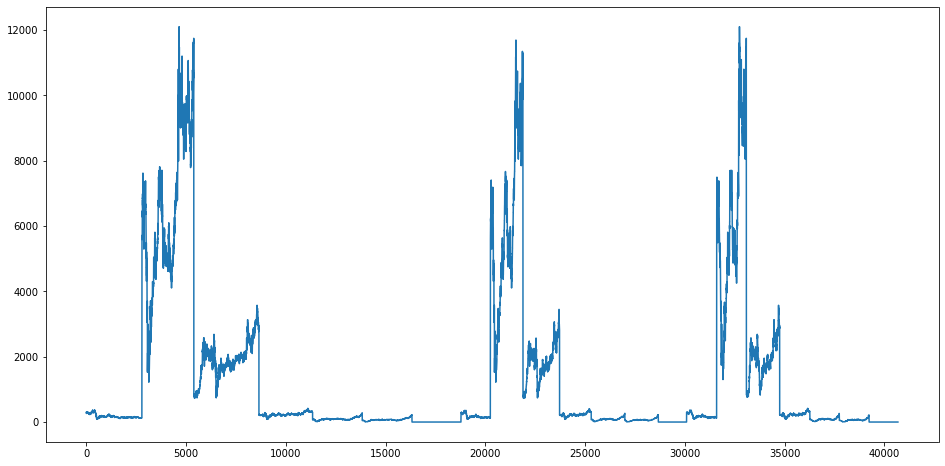

In [304]:
plt.figure(figsize = (16,8))
plt.plot(train_df[1])

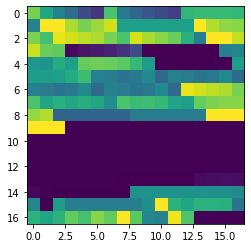

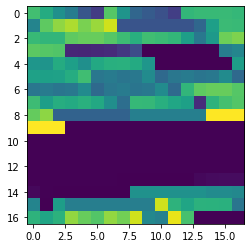

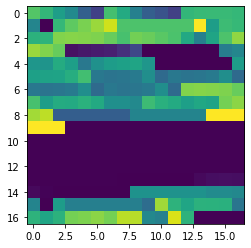

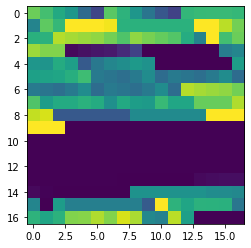

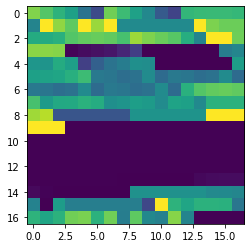

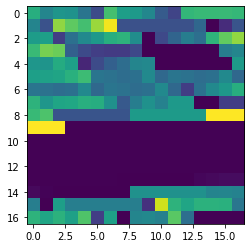

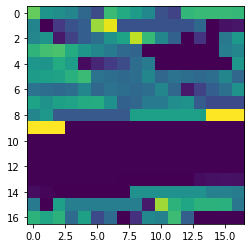

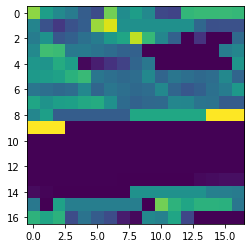

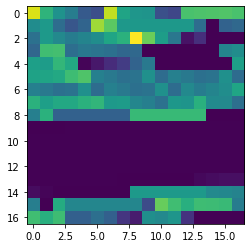

In [307]:
#ПОРИСУЕМ
#train_cnn(train_df, test_df, params)

train_images = train_df.iloc[:, 2:].to_numpy()  # bu satır son sütun hariç her şeyi resimler dataframeine atar.
train_labels = train_df.loc[:, 0]    # bu satır sadece son sütunu alır.
train_prices = train_df.loc[: ,1]

test_images = test_df.iloc[:, 2:].to_numpy()  # bu satır son sütun hariç her şeyi resimler dataframeine atar.
test_labels = test_df.loc[:, 0]   # bu satır sadece son sütunu alır.
test_prices = test_df.loc[:, 1]

test_labels = keras.utils.to_categorical(test_labels, params["num_classes"])
train_labels = keras.utils.to_categorical(train_labels, params["num_classes"])

#create pictures simple reshaping 225 in 15x15+1
train_images = train_images.reshape(train_images.shape[0], params["input_w"], params["input_h"]) 
test_images = test_images.reshape(test_images.shape[0], params["input_w"], params["input_h"])
for i in range(1,10):
    plt.imshow(test_images[i])
    plt.show()